In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image


In [2]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))
#tf.debugging.set_log_device_placement(True)

gpu_device = '/GPU:0'

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
img_size = 400

vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained_model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
print(vgg)

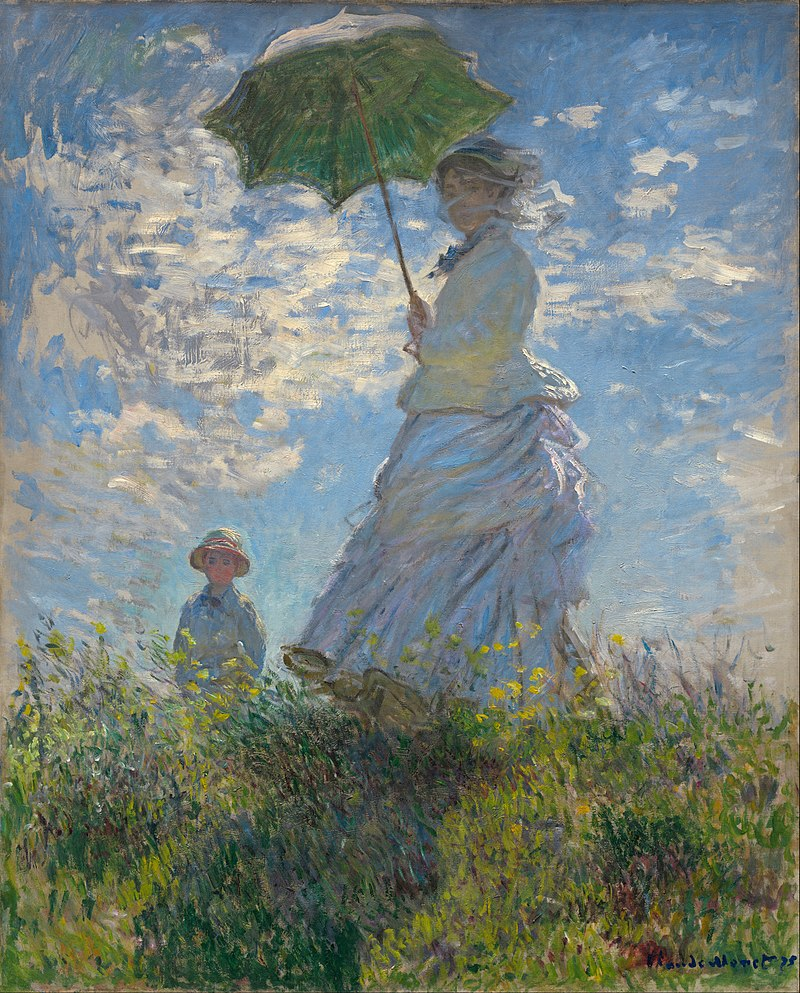

In [4]:
""" Step 1: Computing Content Cost """

content_image = Image.open('images/claude_monet.jpg')
content_image

In [5]:
""" Step 1 would be Calculate the content loss - J_content """

def compute_content_loss(content_output, generated_output):
    """ 
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer representing content of image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer representing content of image G

    Returns:
    J_content -- scalar 
    """

    a_C = content_output[-1]
    a_G = generated_output[-1]

    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Unroll the 4D into a 3D matrix (as number of batch is always 1, will be like 2D ), [spatialsize, channels]
    a_C_unrolled = tf.reshape(a_C, shape=[1, n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1, n_H*n_W, n_C])

    # Compute the total Cost (formula)
    J_content_cost = 1/(4 * n_H * n_W * n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

    return J_content_cost

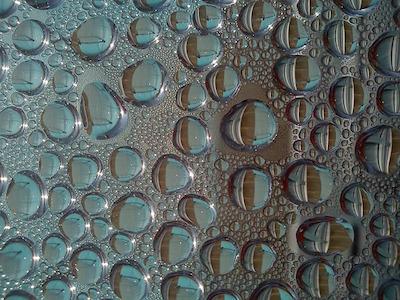

In [6]:
""" Step 2 - Compute the Style cost """
style_image = Image.open('images/drop-of-water.jpg')
style_image

In [7]:
""" In order to calculate the style matrix, first we must calculate the Gram Matrix """

def gram_matrix(A):
    
    GA = tf.matmul(A,A,transpose_b=True)

    return GA

In [8]:
""" Then, we compute the style cost """

def compute_layer_style_cost(a_S, a_G):
    """ 
    Args:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations, represents style of image Style
    a_G -- tensor of dimension (1, n_H, n_W, n_c), hidden layer activations, represents style of image we want Generate
    
    Returns:
    J_style_cost -- tensor representing a scalar value of the hidden layer
    """

    # Retrieve shapes from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # we Unroll the hidden layers as in 'compute_content_cost' function
    a_S_unrolled = tf.reshape(a_S, shape=[1, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1,n_H*n_W,n_C])

    # we compute the gram_matrices for bothh images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Finally we compute the style cost (formula)
    J_style_cost = (1/(4*n_C*n_C*(n_H*n_W)*(n_H*n_H))) * tf.reduce_sum(tf.square(tf.subtract(GS,GG)))

    return J_style_cost

In [9]:
""" Getting the style weigths from pretrained model """

for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [10]:
# I take a layer weigths like this: 

vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [11]:
""" Select of layers to represent the style of the image and assinging a style cost """

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [12]:
""" Compute the full style cost """

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    """ 
    Computes the overall style cost from the several chosen layers before

    Args:
    style_image_output -- our tensorflow model
    generated_image_output --

    
    Returns: 
    J_style -- tensor representing a scalar value.
    """

    J_style = 0

    # Set a_S as hidden layer activations from the layer selected
    a_S = style_image_output[:-1]

    # Set a_G as output of the choosen hidden  layer
    a_G = generated_image_output[:-1]

    # for every layer, compute the layer cost:
    for i, weigths in zip(range(len(a_S)), STYLE_LAYERS):

        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weigths[1] * J_style_layer


    return J_style

In [13]:
""" Once we have J_content and J_style, proceed with the total cost """

def total_cost(J_content, J_style, alpha=10, beta=40):
    """ 
    Computes the total cost function

    Args:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparam
    beta -- hyperparam

    Returns:
    J -- total cost (formula)
    """

    J = alpha * J_content + beta * J_style

    return J

(1, 400, 400, 3)


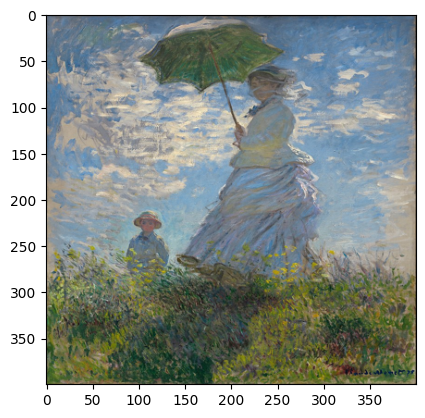

In [14]:
""" Solving the Optimization Problem """

# Loading Content Image
content_image = np.array(Image.open('images/claude_monet.jpg').resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))            # declare it as tensor

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


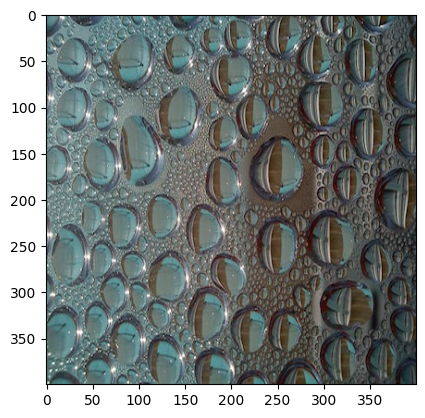

In [15]:
# Loading Style Image
style_image = np.array(Image.open('images/drop-of-water.jpg').resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


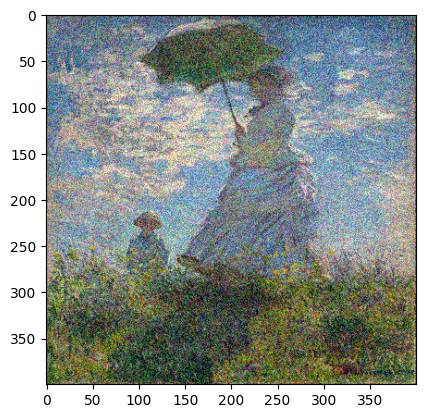

In [16]:
# We have to radomnly intialize the image we want to be generated.

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(content_image), -0.25, 0.25)


generated_image = tf.Variable(tf.add(generated_image, noise))

generated_image = tf.Variable(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

In [17]:
""" Loading the VGG19 layers features """

def get_layer_outputs(vgg, layer_names):
    #Creates a vgg model that returns a list of intermediate output values
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

content_layer = [('block5_conv4'), 1]

vgg_model_output = get_layer_outputs(vgg, STYLE_LAYERS + [content_layer])

#Save the outputs/features of content & style layers
content_target = vgg_model_output(content_image)
style_target = vgg_model_output(style_image)

In [18]:
""" Utils functions to display images """

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

    return Image.fromarray(tensor)

In [19]:
""" Getting the content and style features """

preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_output(preprocessed_content)

preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_output(preprocessed_style)

In [20]:
""" Training steps """

#optimizer:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):

    with tf.device(gpu_device):             #Explicit use of gpu
        
        with tf.GradientTape() as tape:

            a_G = vgg_model_output(generated_image)
            J_style = compute_style_cost(a_S, a_G)
            J_content = compute_content_loss(a_C, a_G)
            J = total_cost(J_content, J_style, alpha=10, beta = 40)

        grad = tape.gradient(J, [generated_image])

        optimizer.apply_gradients(zip(grad, [generated_image]))
        generated_image.assign(clip_0_1(generated_image))

    return J

Epoch 0, total cost:326.7264709472656


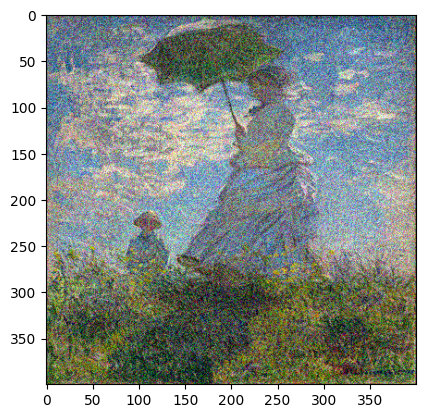

Epoch 250, total cost:1.3751055002212524
Epoch 500, total cost:0.8163186311721802


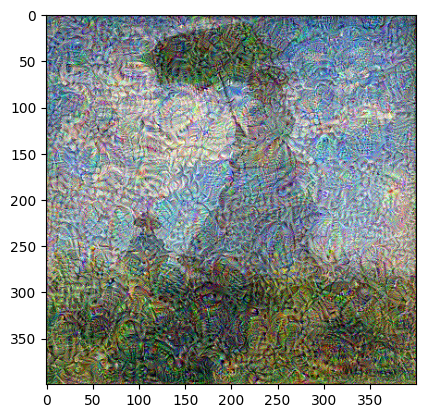

Epoch 750, total cost:0.6235072016716003
Epoch 1000, total cost:0.5202481150627136


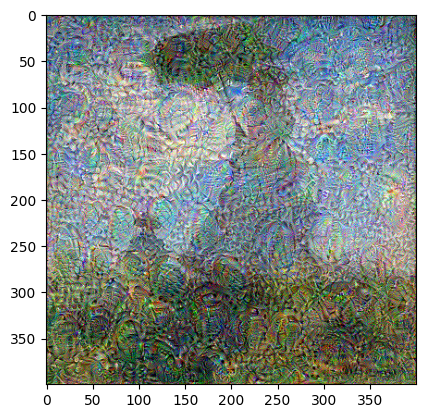

Epoch 1250, total cost:0.4513871371746063
Epoch 1500, total cost:0.4028429687023163


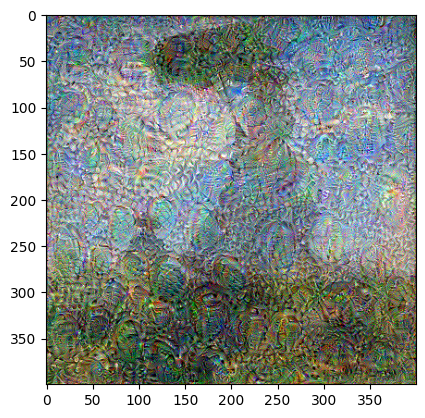

Epoch 1750, total cost:0.36766114830970764
Epoch 2000, total cost:0.3400680422782898


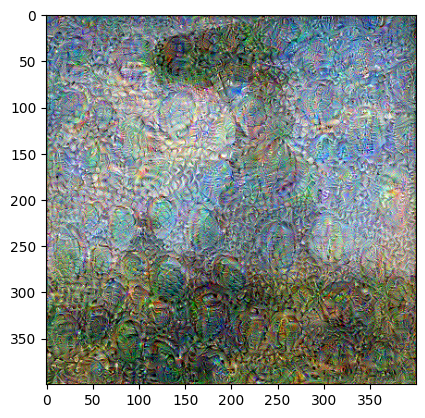

Epoch 2250, total cost:0.3210437297821045
Epoch 2500, total cost:0.3003259599208832


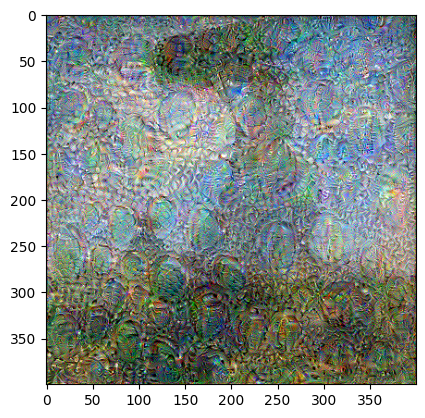

Epoch 2750, total cost:0.28811410069465637
Epoch 3000, total cost:0.2994101941585541


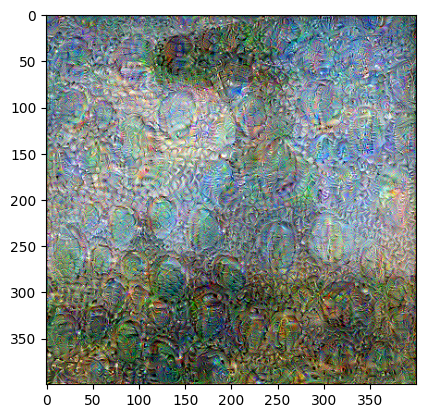

Epoch 3250, total cost:0.2703869938850403
Epoch 3500, total cost:0.27173179388046265


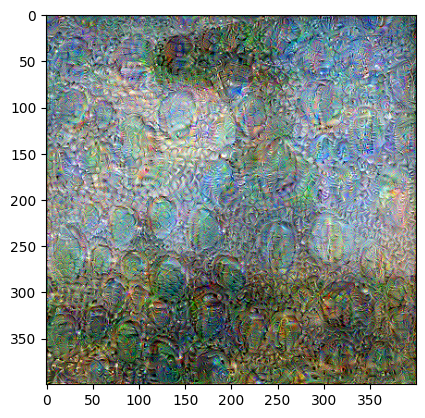

Epoch 3750, total cost:0.27340972423553467
Epoch 4000, total cost:0.2403237521648407


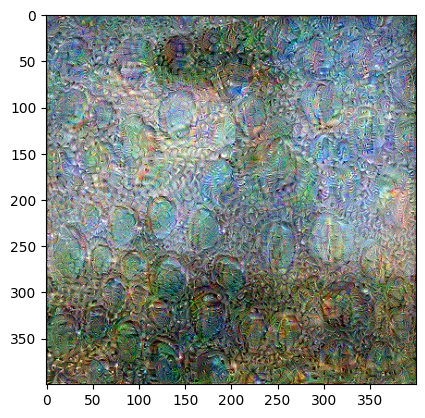

In [ ]:
""" All together """

epochs = 4001
for i in range(epochs):

    J = train_step(generated_image)

    if(i % 250 == 0):
        print(f"Epoch {i}, total cost:{J}")
    if(i % 1250 == 0):
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        plt.show()

In [22]:
image.save('generated_images/water_monet.jpg')

from tensorflow.keras import backend as K
K.clear_session()

